# Pathway Enrichment of LR loadings

Cell-cell communication inference from single-cell data provides unprecedented insights into the molecular mechanisms underlying cell-cell communication. In particular, it enables the capture of CCC interactions at a systems level, which is not possible with traditional approaches. However, as the number of inferred interactions increases, the interpretation of the inferred cell-cell communication networks becomes more challenging. To this end, as done in other omics studies, we can perform pathway enrichment analysis to identify the general biological processes that are enriched in the inferred interactions. Pathway enrichment thus serves two purposes; it reduces the dimensionality of the inferred interactions, and also provides a biological summary of the inferred interactions.

In this tutorial, we will show how to use the `cell2cell` and `liana` packages to perform classical gene set enrichment analysis using `GSEA` with `GO terms`, and also we will use perform a footprint enrichment analysis using a `multi-variate linear model` with the PROGENy pathway resource. We will use the [`GSEAPY`](https://gseapy.readthedocs.io/en/latest/) and [`decoupler-py`](https://decoupler-py.readthedocs.io/en/latest) packages to perform these analyses.

In [157]:
import pandas as pd

import seaborn as sns
%matplotlib inline
import plotnine as p9

import cell2cell as c2c
import liana as li

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Directories

In [9]:
output_folder = '../../data/'
c2c.io.directories.create_directory(output_folder)

../../data/ already exists.


## Load Data

**Open the loadings obtained from the tensor factorization**

In [11]:
factors = c2c.io.load_tensor_factors(output_folder + 'loadings.xlsx')

**Load list of LR pairs used as reference to [run LIANA](./02-Infer-Communication-Scores.ipynb)**

In [151]:
lr_pairs = li.resource.select_resource('consensus')

**Generate a list with the LR pair names**

GSEA was originally designed to work with list of genes. Here we are using ligand-receptor pairs, so instead of using Gene Sets we need to build our LR-gene sets. This list is a first step to build the LR-gene sets.

In [13]:
lr_list = ['^'.join(row) for idx, row in lr_pairs.iterrows()] 

## GO term enrichment

In this case, we will run the PreRank method of GSEA since our LR pairs are pre-ranked based on their loadings in each factor obtained by Tensor-cell2cell.

### Generate LR-gene set for running GSEA

`cell2cell` includes some resources associated with the Gene sets employed in GSEA. It includes annotations of GO Terms (BP), KEGG, and Reactome, for human and mouse.

**First, specify which organism and annotation DB to use**

In [14]:
organism = 'human' # For the COVID-19 data analyzed with LIANA+Tensor-cell2cell
pathwaydb = 'GOBP' # GO Terms (Biological Processes)

**Generate the LR-gene set that will be used for running GSEA**

In [15]:
lr_set = c2c.external.generate_lr_geneset(lr_list,
                                          complex_sep='_', # Separation symbol of the genes in the protein complex
                                          lr_sep='^', # Separation symbol between a ligand and a receptor complex
                                          organism=organism,
                                          pathwaydb=pathwaydb,
                                          readable_name=True
                                         )

100%|██████████| 4.83M/4.83M [00:02<00:00, 1.74MB/s]


### Extract LR loadings for each factor

In [152]:
lr_loadings = factors['Ligand-Receptor Pairs']

### Run GSEA

This external function implemented in `cell2cell` builds upon the function `gseapy.prerank()`.

In [132]:
%%time
pvals, scores, gsea_df = c2c.external.run_gsea(loadings=lr_loadings, 
                                               lr_set=lr_set,
                                               output_folder=output_folder,
                                               weight=1,
                                               min_size=15,
                                               permutations=999,
                                               processes=6,
                                               random_state=6,
                                               significance_threshold=0.05,
                                              )

  0%|          | 0/10 [00:00<?, ?it/s]2023-02-03 11:03:12,987 [WARNING] Duplicated values found in preranked stats: 26.06% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


../../data/ already exists.


 10%|█         | 1/10 [00:01<00:11,  1.23s/it]2023-02-03 11:03:14,216 [WARNING] Duplicated values found in preranked stats: 31.20% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
 20%|██        | 2/10 [00:02<00:11,  1.47s/it]2023-02-03 11:03:15,864 [WARNING] Duplicated values found in preranked stats: 31.94% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
 30%|███       | 3/10 [00:04<00:10,  1.43s/it]2023-02-03 11:03:17,249 [WARNING] Duplicated values found in preranked stats: 26.43% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
 40%|████      | 4/10 [00:05<00:07,  1.32s/it]2023-02-03 11:03:18,392 [WARNING] Duplicated values found in preranked stats: 26.06% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
 50%|█████     | 5/10 [00:06<00:06,  1.25s/it]2023-02-03 11:03:19,509 [WARNING] Duplicated values found in prera

CPU times: user 1min 2s, sys: 1.05 s, total: 1min 3s
Wall time: 22.7 s


### Visualization

We can use the `pvals` and `scores`outputs to visualize the results as a Dot Plot:

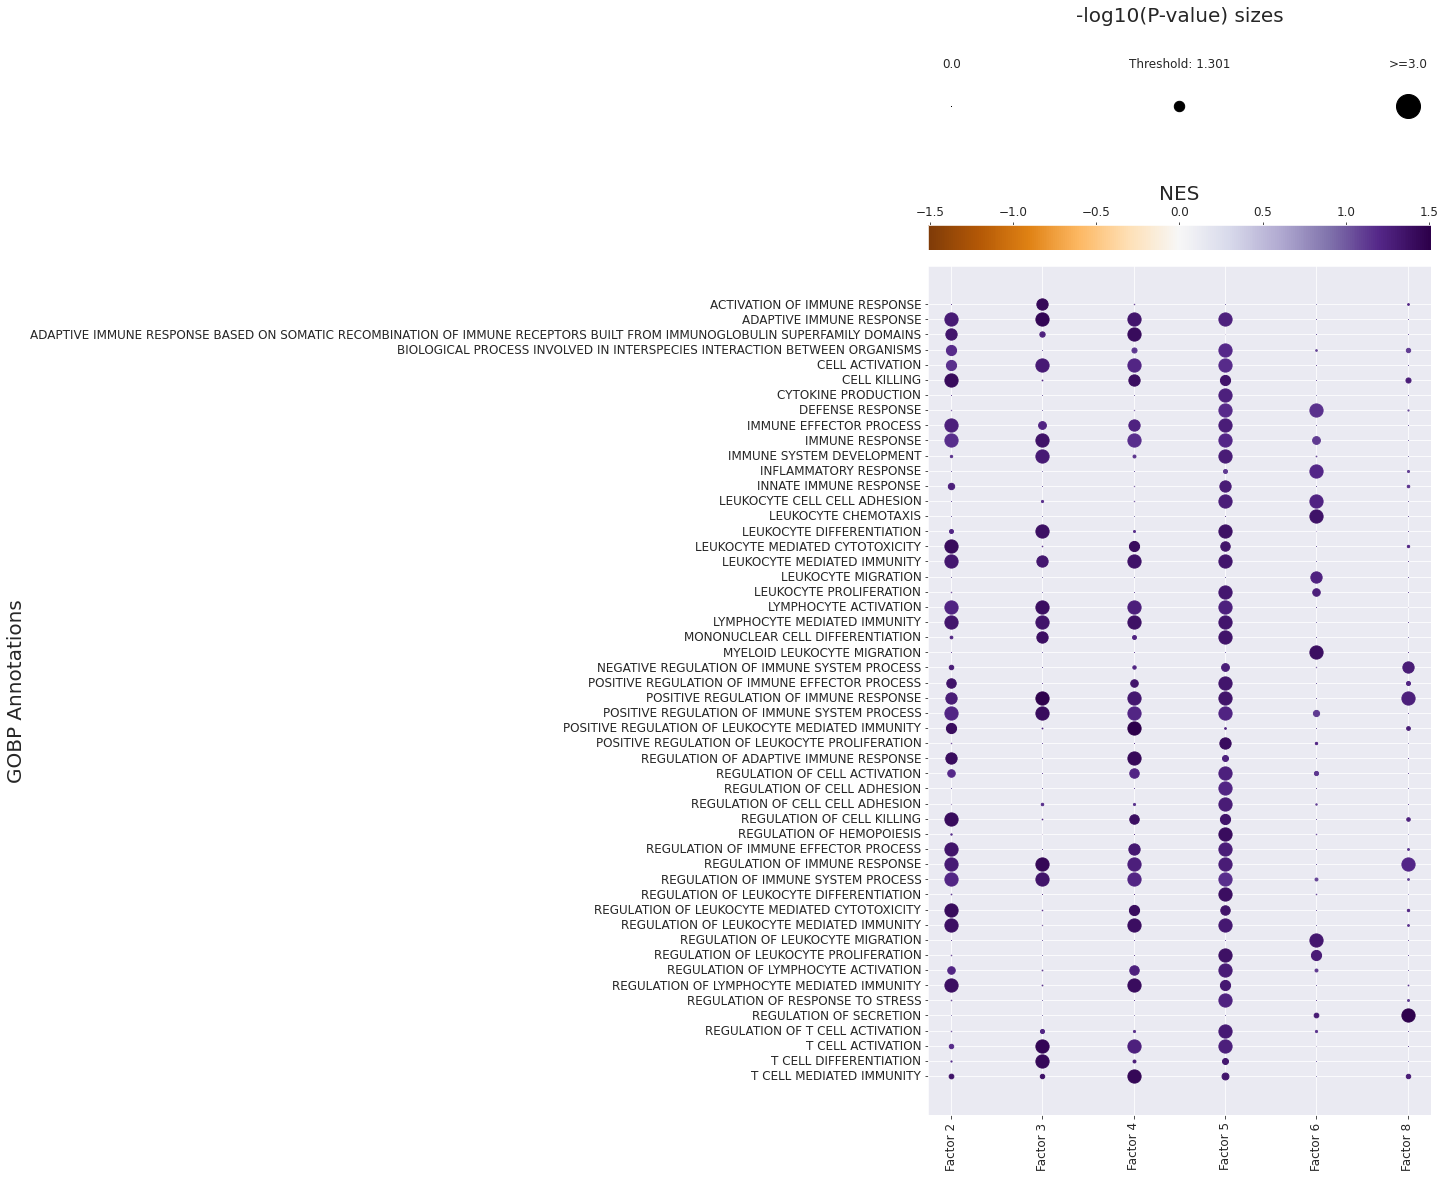

In [10]:
with sns.axes_style("darkgrid"):
    dotplot = c2c.plotting.pval_plot.generate_dot_plot(pval_df=pvals,
                                                       score_df=scores,
                                                       significance=0.05,
                                                       xlabel='',
                                                       ylabel='{} Annotations'.format(pathwaydb),
                                                       cbar_title='NES',
                                                       cmap='PuOr',
                                                       figsize=(9, 20),
                                                       label_size=20,
                                                       title_size=20,
                                                       tick_size=12,
                                                       filename=output_folder + '/GSEA-Dotplot.pdf'
                                                      )

**Similarly, we can use gsea_df to easily see the Enriched Pathways**

In [18]:
gsea_df.loc[(gsea_df['Adj. P-value'] < 0.05) & (gsea_df['NES'] > 0.)]

,Factor,Term,NES,P-value,Adj. P-value
0,Factor 2,ADENYLATE CYCLASE MODULATING G PROTEIN COUPLED...,1.233462,0.001001,0.043504
28,Factor 2,DEFENSE RESPONSE,1.081011,0.001000,0.043504
33,Factor 2,G PROTEIN COUPLED RECEPTOR SIGNALING PATHWAY,1.076501,0.001001,0.043504
35,Factor 2,BIOLOGICAL PROCESS INVOLVED IN INTERSPECIES IN...,1.074910,0.001000,0.043504
48,Factor 2,IMMUNE RESPONSE,1.062391,0.001000,0.043504
...,...,...,...,...,...
2955,Factor 10,LEUKOCYTE CELL CELL ADHESION,1.095479,0.001001,0.043504
2961,Factor 10,REGULATION OF IMMUNE RESPONSE,1.086796,0.001000,0.043504
2965,Factor 10,T CELL ACTIVATION,1.082381,0.001000,0.043504
2985,Factor 10,IMMUNE RESPONSE,1.062912,0.001000,0.043504


**And Depleted Pathways**

In [21]:
gsea_df.loc[(gsea_df['Adj. P-value'] < 0.05) & (gsea_df['NES'] < 0.)]

,Factor,Term,NES,P-value,Adj. P-value


## Footprint Enrichment

Footprint enrichment analysis build upon classic geneset enrichment analysis, as instead of considering the genes involved in a biological activity, they consider the genes affected by the activity, or in other words the genes that change downstream of said activity [(Dugourd and Saez-Rodriguez, 2019)](https://www.sciencedirect.com/science/article/pii/S2452310019300149). This is particularly useful when working with transcriptomics data, as it allows to identify the genes that are regulated by a biological process, instead of the genes that are part of the process. In this case, we will use the PROGENy pathway resource to perform footprint enrichment analysis. PROGENy was built in a data-driven manner using perturbation and cancer lineage data [(Schubert et al, 2019)](https://www.nature.com/articles/s41467-017-02391-6#Sec8), as a consequence it also assigns different importances or weights to each gene in its pathway genesets.

To this end, we need an enrichment method that can take weights into account, and here we will use multi-variate linear models from the `decoupler-py` package to perform this analysis [(Badia-i-Mompel et al., 2022)](https://academic.oup.com/bioinformaticsadvances/article/2/1/vbac016/6544613).

In [56]:
import decoupler as dc
from liana.funcomics import generate_lr_geneset
from anndata import AnnData

###  load the PROGENy pathway resource:

In [202]:
net = dc.get_progeny(organism='human', top=5000)

Now we will use the PROGENy genesets to assign pathways and weights to the ligand-receptor pairs in liana's consensus resource. Specifically, we will use the weighted bipartite networks from PROGENy, where the weight represents the importance of the genes to a given geneset, and assign a weight to each ligand-receptor interaction, based on the mean of the weights of the proteins in that ligand-receptor interaction. We keep only ligand-receptor weights only if all the protein in the ligand-receptor interaction are present for a given pathway, and are sign-coherent.

In [203]:
lr_progeny = generate_lr_geneset(lr_pairs, net, lr_separator="^")
lr_progeny.head()

,source,interaction,weight
1,JAK-STAT,LGALS9^PTPRC,1.307807
74,Androgen,SEMA4D^MET,-0.831693
90,Androgen,HGF^MET,-1.288956
106,Androgen,TIMP3^MET,-1.122612
151,NFkB,SELE^CD44,3.332552


### Run footprint enrichment analysis

We will now use the `decoupler-py` package to perform the analysis.

In [204]:
estimate, pvals =  dc.run_mlm(lr_loadings.transpose(), lr_progeny, source="source", target="interaction", use_raw=False)

### Visualize Results

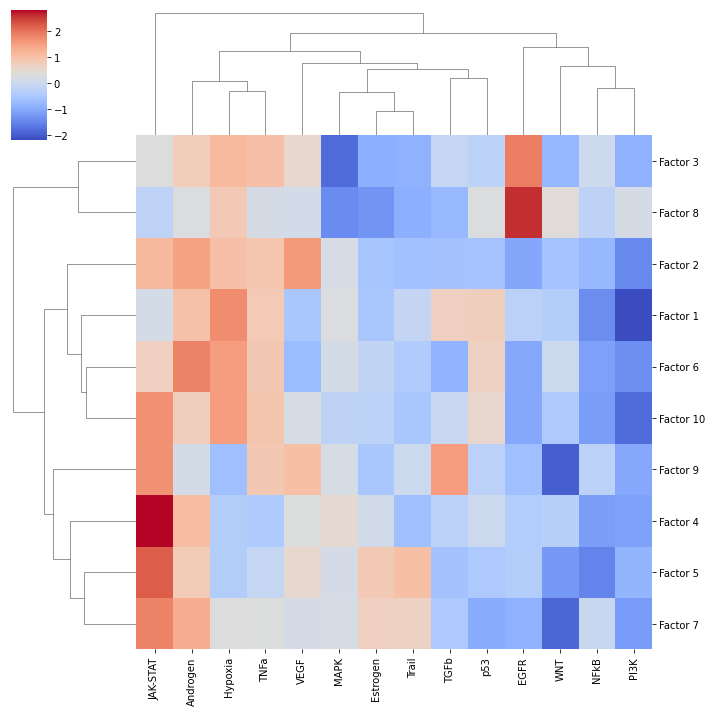

In [205]:
sns.clustermap(estimate, xticklabels=estimate.columns, cmap='coolwarm', z_score=4)

Let's zoom in on Factor 4, which was most associated most to the condition across contexts and visualize the p-values to the enrichment scores:

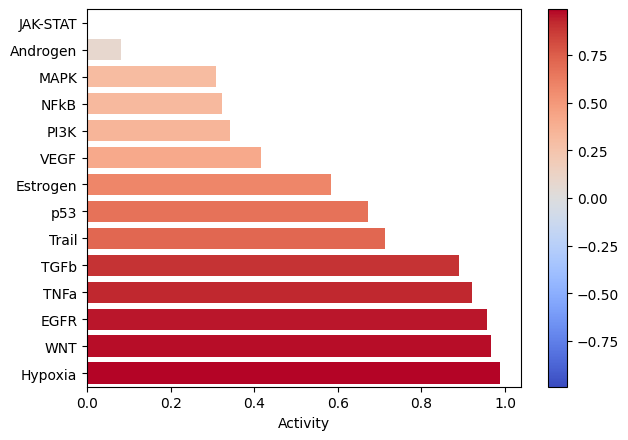

In [206]:
dc.plot_barplot(pvals, 'Factor 4', vertical=True)

From the plots above, we can see that the JAK-STAT pathway is active and highly significant in Factor 4, so let's see which ligand-receptor pairs are enriched in this pathway.

In [318]:
# loadings to long format
lr_loadings_long = lr_loadings.reset_index().melt(id_vars='index', var_name="Factor", value_name="Loadings").rename(columns={'index':'interaction'})
# join progeny weights and keep only JAK-STAT pathway
lr_loadings_long = lr_loadings_long.merge(lr_progeny, on='interaction').query("source == 'JAK-STAT' and Factor == 'Factor 4'")
# add sign to the weights
lr_loadings_long['sign'] = lr_loadings_long['weight'].apply(lambda x: 'positive' if x > 0 else 'negative')
# keep only relevant interactions for labels
lr_loadings_long['relevant_interactions'] = lr_loadings_long.apply(lambda x: x['interaction'] if (x['Loadings'] > 0.025) and (x['weight'] > 2.5) else None, axis=1)
lr_loadings_long.head()

,interaction,Factor,Loadings,source,weight,sign,relevant_interactions
483,APOA1^LDLR,Factor 4,2.269091e-21,JAK-STAT,0.766587,positive,None
906,B2M^LILRB2,Factor 4,1.284372e-80,JAK-STAT,1.428233,positive,None
1236,CCL13^ACKR4,Factor 4,2.269091e-21,JAK-STAT,1.022143,positive,None
1253,CCL13^CCR1,Factor 4,7.038378e-123,JAK-STAT,0.785547,positive,None
1273,CCL13^CXCR3,Factor 4,1.775324e-03,JAK-STAT,0.322813,positive,None


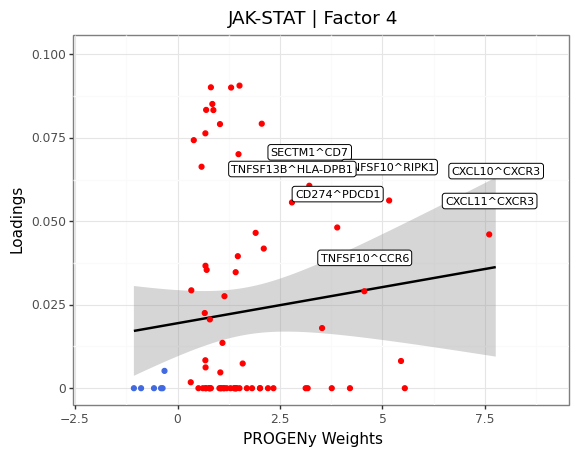

<ggplot: (8787257344904)>

In [319]:
# plot the loadings for Factor 4 and weights of the JAK-STAT pathway
(p9.ggplot(lr_loadings_long,
           p9.aes(x='weight', y='Loadings')) +
 p9.geom_smooth(method='lm') + 
 p9.geom_point(p9.aes(colour='sign')) +
 p9.theme_bw() +
 p9.theme(legend_position='none') +
 p9.labs(title="JAK-STAT | Factor 4", x="PROGENy Weights", y="Loadings") +
 p9.scale_colour_manual(values=["royalblue", "red"]) +
 p9.geom_label(p9.aes(label='relevant_interactions'), size=8, nudge_y=0.01, nudge_x=0.01) + 
 p9.xlim(-2, 9)
 )

Here, we can see that for example the `CXL10 -> CXCR3` and `TNFS10 -> CCR6` are interactions found with high importances in the JAK-STAT pathway, that are also with high loadings in Factor 4.